<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Probability_Base_Model_separate_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 4.3 MB/s 


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit
from sklearn.metrics import confusion_matrix

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

In [13]:
train_df.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [14]:
P1 = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']
P2 = ['AIT201', 'AIT202','AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206']
P3 = ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302']
P4 = ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401']
P5 = ['AIT501', 'AIT502', 'AIT503', 'AIT504','FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503']
P6 = ['FIT601', 'P601', 'P602', 'P603']

Model Prediction on each stage

In [15]:
from  pyod.models.ecod import ECOD
model = ECOD(contamination=0.000000001)

In [16]:
def get_test_score(stage,train_scale,test_scale):
  norm_test_scores = []
  test_scores = []
  train_scores = []
  norm_train_scores = []
  trainning_time = []
  prediction_time = []

  for i in stage:
    model = ECOD(contamination=0.000000001)
    start = timeit.default_timer()
    model.fit(train_scale[i])
    end = timeit.default_timer()

    train_score = model.decision_scores_
    start_pred = timeit.default_timer()
    test_score = model.decision_function(test_scale[i])
    end_pred = timeit.default_timer()

    test_scores.append(test_score)
    train_scores.append(train_score)

    trainning_time.append(end-start)
    prediction_time.append(end_pred-start_pred)

    #normalise train&test score
    min_train = min(train_score)
    max_train = max(train_score)
    norm_train = (train_score-min_train)/(max_train-min_train)
    norm_test = (test_score - min_train)/(max_train-min_train)

    norm_test_scores.append(norm_test)
    norm_train_scores.append(norm_train)

    print(f"------ Finish Stage {i} ------")
  return norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time


In [17]:
stage = [P1,P2,P3,P4,P5,P6]

In [18]:
norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time = get_test_score(stage,train_scale,test_scale)

------ Finish Stage ['FIT101', 'LIT101', 'MV101', 'P101', 'P102'] ------
------ Finish Stage ['AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206'] ------
------ Finish Stage ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302'] ------
------ Finish Stage ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401'] ------
------ Finish Stage ['AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503'] ------
------ Finish Stage ['FIT601', 'P601', 'P602', 'P603'] ------


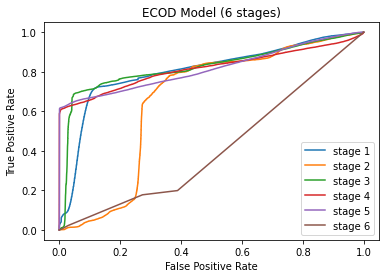

In [19]:
aucs = []
for i in range(len(norm_test_scores)):
  fpr, tpr, _ = metrics.roc_curve(label,  test_scores[i])
  auc = metrics.roc_auc_score(label,  test_scores[i])
  aucs.append(auc)
  plt.plot(fpr,tpr,label=f"stage {i+1}")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(f'ECOD Model (6 stages)')
  plt.legend(loc=4)

In [20]:
for i in range(len(aucs)):
  print(f"AUC stage{i+1}: {np.round(aucs[i],3)}, training time = {trainning_time[i]}, prediction_time = {prediction_time[i]}")

AUC stage1: 0.805, training time = 2.256921582000018, prediction_time = 3.8153848240000343
AUC stage2: 0.657, training time = 2.5654174160000593, prediction_time = 6.248074105000001
AUC stage3: 0.824, training time = 3.2982943590000104, prediction_time = 6.455544981000003
AUC stage4: 0.818, training time = 1.926922582999964, prediction_time = 2.6592516990000377
AUC stage5: 0.816, training time = 2.152887905000057, prediction_time = 4.409577974000058
AUC stage6: 0.413, training time = 0.49340206599993053, prediction_time = 1.021795482000016


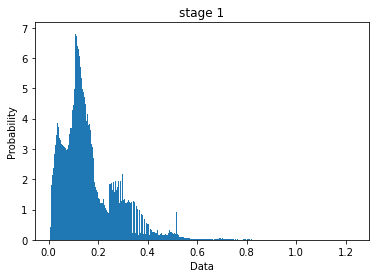

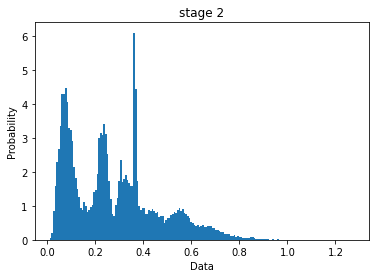

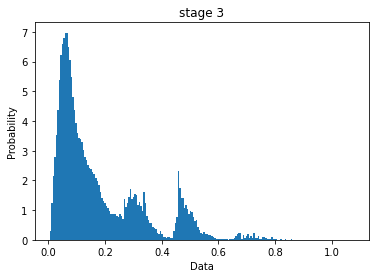

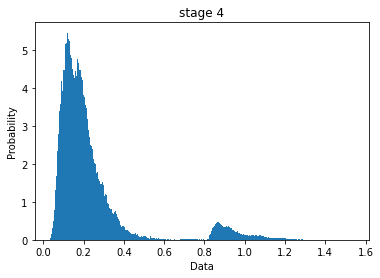

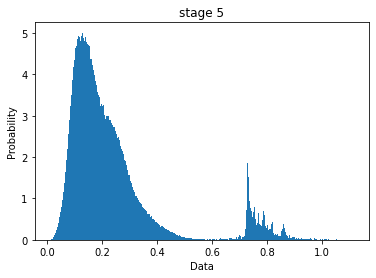

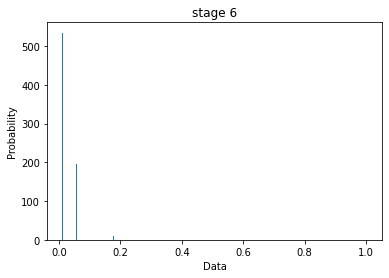

In [21]:
for i in range(len(norm_test_scores)):
  plt.hist(norm_test_scores[i], density=True, bins='auto')  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')
  plt.title(f'stage {i+1}')
  plt.show()

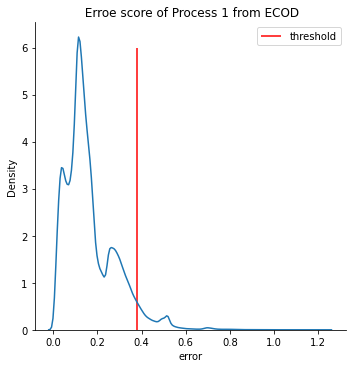

In [435]:
sns.displot(data=pd.DataFrame(norm_test_scores[0], columns = ['error']), x="error", kind="kde")
plt.title(' Erroe score of Process 1 from ECOD')
plt.vlines(np.percentile(norm_test_scores[0],95),ymin =0, ymax = 6,color = 'red', label = 'threshold')
plt.legend()

In [22]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
    else:
      pred_label[i:i+time_window] = 0

  return pred_label

In [23]:
time_window = 1

##Ture Attack point

In [24]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [25]:
true_attack = true_anomaly[~true_anomaly["End Time"].isnull()]

In [26]:
true_attack.tail(3)

,Attack #,Start Time,End Time,Attack Point,Start State,Attack,Actual Change,Expected Impact or attacker intent,Unexpected Outcome
38,39,2/01/2015 11:43:48,11:50:28,"FIT-401, AIT-502",In Normal Range,Set value of FIT-401 as 0.5; Set value of AIT-...,No,UV will shut down and water will go to RO,UV did not shutdown
39,40,2/01/2015 11:51:42,11:56:38,FIT-401,In Normal Range,Set value of FIT-401 as 0,No,UV will shut down and water will go to RO,"P-402 did not close, both should be interlinked"
40,41,2/01/2015 13:13:02,13:40:56,LIT-301,Water level between L and H,decrease value by 0.5 mm per second,No,Tank overflow,Rate of decrease in water level reduced after ...


In [139]:
true_attack['Attack #']

0      1
1      2
2      3
3      4
5      6
6      7
7      8
9     10
10    11
12    13
13    14
15    16
16    17
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
Name: Attack #, dtype: object

In [27]:
start_time = true_attack['Start Time']
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [28]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [29]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [30]:
len(start_time) #there are 36 attack

36

In [31]:
n_att = start_time.index.values+1
start_time.index.values+1

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41])

In [32]:
label

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
time_label = pd.DataFrame(label, index =  test_df.index.values, columns = ["label"])
time_label.reset_index(inplace=True)
time_label.rename(columns = {'index':'Timestamp'}, inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label['Timestamp'])

In [34]:
time_label

,Timestamp,label
0,2015-12-28 10:00:00,0
1,2015-12-28 10:00:01,0
2,2015-12-28 10:00:02,0
3,2015-12-28 10:00:03,0
4,2015-12-28 10:00:04,0
...,...,...
449914,2016-02-01 14:59:55,0
449915,2016-02-01 14:59:56,0
449916,2016-02-01 14:59:57,0
449917,2016-02-01 14:59:58,0


In [35]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [36]:
idx_start

array([  1754,   3068,   4920,   6459,   7255,   7705,  11410,  15380,
        15540,  90685,  92140,  93445, 103092, 115843, 116143, 117000,
       132918, 142954, 172268, 172910, 198296, 227828, 229519, 279120,
       280060, 302653, 347679, 361191, 371479, 371855, 389680, 436541,
       437417, 438147, 438621, 443501])

In [37]:
time_label['attack #'] = 0
for i in range (len(n_att)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = n_att[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##tunning threshold from stage P1

In [38]:
!pip install ghostml --quiet

In [39]:
import ghostml
n_percentile = [np.percentile(norm_test_scores,i) for i in range(95,100,1)]

In [40]:
threshold1 = ghostml.optimize_threshold_from_predictions(label, norm_test_scores[0], n_percentile, ThOpt_metrics = 'Kappa') 

In [41]:
threshold1

0.5430184044914178

In [42]:
n_percentile #use percentil 95

[0.5430184044914178,
 0.5977952603117432,
 0.70205805524962,
 0.7658072620141095,
 0.873483968111011]

##Stage P1

In [43]:
t1 = np.percentile(norm_test_scores[0],95)

In [44]:
label_1 = pred_labels_timewindow(norm_test_scores[0],t1,time_window)

In [45]:
time_label["pred_1"] = label_1

In [46]:
att_p1 = time_label[time_label['attack #'].isin([1,2,3,21,26,30,33,34,35,36])]

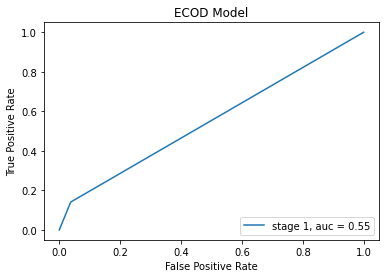

In [47]:
fpr, tpr, _ = metrics.roc_curve(label, label_1)
auc = metrics.roc_auc_score(label, label_1)
plt.plot(fpr,tpr,label=f"stage 1, auc = {np.round(auc,2)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ECOD Model')
plt.legend(loc=4)

In [48]:
print(metrics.classification_report(label,label_1))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    395298
           1       0.34      0.14      0.20     54621

    accuracy                           0.86    449919
   macro avg       0.62      0.55      0.56    449919
weighted avg       0.82      0.86      0.84    449919



[[380495  14803]
 [ 46928   7693]]


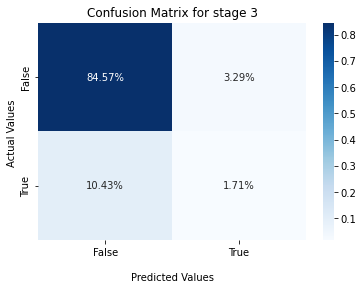

In [49]:
cm = confusion_matrix(label,label_1)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [50]:
print(metrics.classification_report(att_p1.label,att_p1.pred_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.70      0.82      6669

    accuracy                           0.70      6669
   macro avg       0.50      0.35      0.41      6669
weighted avg       1.00      0.70      0.82      6669



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
found = []
for i in range(len(att_p1)):
  if (att_p1.iloc[i]["pred_1"] == 1) & (att_p1.iloc[i]["label"] == 1):
    found.append(att_p1.iloc[i]["attack #"])
print(np.unique(found))

[ 1  2  3 26 30 33 34 35 36]


In [52]:
np.unique(att_p1["attack #"])

array([ 1,  2,  3, 21, 26, 30, 33, 34, 35, 36])

##Stage P2

In [53]:
t2 = np.percentile(norm_test_scores[1],95)

In [54]:
t2

0.6327029702186139

In [55]:
label_2 = pred_labels_timewindow(norm_test_scores[1],t2,time_window)

In [56]:
print(metrics.classification_report(label,label_2))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91    395298
           1       0.04      0.01      0.02     54621

    accuracy                           0.83    449919
   macro avg       0.46      0.48      0.46    449919
weighted avg       0.77      0.83      0.80    449919



[[373606  21692]
 [ 53806    815]]


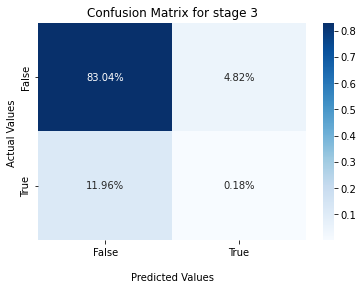

In [57]:
cm = confusion_matrix(label,label_2)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [58]:
time_label["pred_2"] = label_2

In [59]:
att_p2 = time_label[time_label['attack #'].isin([6,24,29])]

In [60]:
found = []
for i in range(len(att_p2)):
  if (att_p2.iloc[i]["pred_2"] == 1) & (att_p2.iloc[i]["label"] == 1):
    found.append(att_p2.iloc[i]["attack #"])
print(np.unique(found))

[24]


In [61]:
print(metrics.classification_report(att_p2.label,att_p2.pred_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.09      0.16       638

    accuracy                           0.09       638
   macro avg       0.50      0.04      0.08       638
weighted avg       1.00      0.09      0.16       638



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Stage P3

In [62]:
t3 = np.percentile(norm_test_scores[2],95)

In [63]:
t3

0.5003064776799223

In [64]:
label_3 = pred_labels_timewindow(norm_test_scores[2],t3,time_window)

In [65]:
print(metrics.classification_report(label,label_3))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94    395298
           1       0.59      0.25      0.35     54621

    accuracy                           0.89    449919
   macro avg       0.75      0.61      0.64    449919
weighted avg       0.87      0.89      0.87    449919



[[386084   9214]
 [ 41096  13525]]


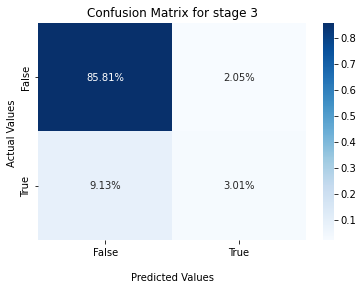

In [66]:
cm = confusion_matrix(label,label_3)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [67]:
time_label["pred_3"] = label_3

In [68]:
att_p3 = time_label[time_label['attack #'].isin([7,8,13,14,16,17,23,26,27,28,32,41])]

In [69]:
found = []
for i in range(len(att_p3)):
  if (att_p3.iloc[i]["pred_3"] == 1) & (att_p3.iloc[i]["label"] == 1):
    found.append(att_p3.iloc[i]["attack #"])
print(np.unique(found))

[ 8 17 23 26 28 41]


In [70]:
print(metrics.classification_report(att_p3.label,att_p3.pred_3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.31      0.47     43368

    accuracy                           0.31     43368
   macro avg       0.50      0.15      0.23     43368
weighted avg       1.00      0.31      0.47     43368



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Stage P4

In [71]:
t4 = np.percentile(norm_test_scores[3],95)

In [72]:
t4

0.8815313857317895

In [73]:
label_4 = pred_labels_timewindow(norm_test_scores[3],t4,time_window)

In [74]:
print(metrics.classification_report(label,label_4))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    395298
           1       1.00      0.41      0.58     54621

    accuracy                           0.93    449919
   macro avg       0.96      0.71      0.77    449919
weighted avg       0.93      0.93      0.91    449919



[[395217     81]
 [ 32203  22418]]


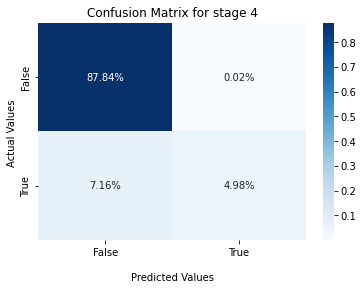

In [75]:
cm = confusion_matrix(label,label_4)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 4');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [76]:
time_label["pred_4"] = label_4

In [77]:
att_p4 = time_label[time_label['attack #'].isin([10,11,22,25,31,38,39,40])]

In [78]:
found = []
for i in range(len(att_p4)):
  if (att_p4.iloc[i]["pred_4"] == 1) & (att_p4.iloc[i]["label"] == 1):
    found.append(att_p4.iloc[i]["attack #"])
print(np.unique(found))

[]


In [79]:
print(metrics.classification_report(att_p4.label,att_p4.pred_4))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    3142.0

    accuracy                           0.00    3142.0
   macro avg       0.00      0.00      0.00    3142.0
weighted avg       0.00      0.00      0.00    3142.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

##Stage P5

In [80]:
t5 = np.percentile(norm_test_scores[4],95)

In [81]:
t5

0.74094302851048

In [82]:
label_5 = pred_labels_timewindow(norm_test_scores[4],t5,time_window)

In [83]:
print(metrics.classification_report(label,label_5))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    395298
           1       0.99      0.41      0.58     54621

    accuracy                           0.93    449919
   macro avg       0.96      0.70      0.77    449919
weighted avg       0.93      0.93      0.91    449919



[[395126    172]
 [ 32295  22326]]


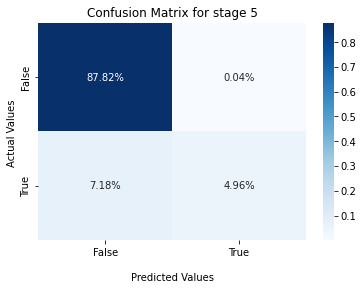

In [84]:
cm = confusion_matrix(label,label_5)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 5');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [85]:
time_label["pred_5"] = label_5

In [86]:
att_p5 = time_label[time_label['attack #'].isin([4,19,20,22,37,38,39])]

In [87]:
found = []
for i in range(len(att_p5)):
  if (att_p5.iloc[i]["pred_5"] == 1) & (att_p5.iloc[i]["label"] == 1):
    found.append(att_p5.iloc[i]["attack #"])
print(np.unique(found))

[22 37]


In [88]:
print(metrics.classification_report(att_p5.label,att_p5.pred_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.05      0.09      2658

    accuracy                           0.05      2658
   macro avg       0.50      0.02      0.04      2658
weighted avg       1.00      0.05      0.09      2658



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Stage P6

In [89]:
t6 = np.percentile(norm_test_scores[5],98)

In [90]:
t6

0.177549398921028

In [91]:
label_6 = pred_labels_timewindow(norm_test_scores[5],t6,time_window)

In [92]:
print(metrics.classification_report(label,label_6))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    395298
           1       0.10      0.02      0.04     54621

    accuracy                           0.85    449919
   macro avg       0.49      0.50      0.48    449919
weighted avg       0.78      0.85      0.81    449919



[[383369  11929]
 [ 53364   1257]]


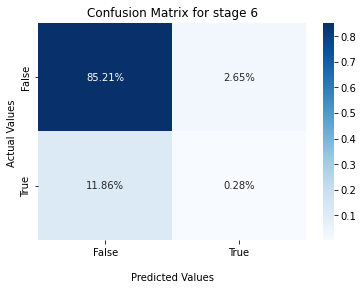

In [93]:
cm = confusion_matrix(label,label_6)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 6');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [94]:
time_label["pred_6"] = label_6

In [95]:
att_p6 = time_label[time_label['attack #'].isin([23])]

In [96]:
found = []
for i in range(len(att_p6)):
  if (att_p6.iloc[i]["pred_6"] == 1) & (att_p6.iloc[i]["label"] == 1):
    found.append(att_p6.iloc[i]["attack #"])
print(np.unique(found))

[23]


In [97]:
print(metrics.classification_report(att_p6.label,att_p6.pred_6))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.03      0.06       697

    accuracy                           0.03       697
   macro avg       0.50      0.02      0.03       697
weighted avg       1.00      0.03      0.06       697



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0]
 [674  23]]


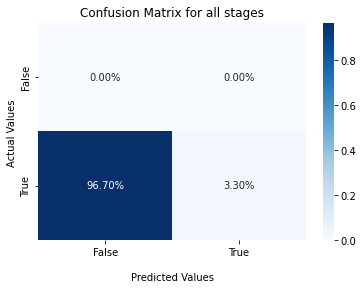

In [98]:
cm = confusion_matrix(att_p6.label,att_p6.pred_6)

print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for all stages');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

##Attack found

In [99]:
time_label['pred'] = np.where((time_label['pred_1'] ==1) | 
                              (time_label['pred_2'] ==1) |
                              (time_label['pred_3'] ==1) |
                              (time_label['pred_4'] ==1) |
                              (time_label['pred_5'] ==1) |
                              (time_label['pred_6'] ==1), 1, 0)


In [100]:
time_label[time_label["label"] == 1].tail(5)

,Timestamp,label,attack #,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred
445186,2016-02-01 13:41:07,1,0,0,0,1,0,0,0,1
445187,2016-02-01 13:41:08,1,0,0,0,1,0,0,0,1
445188,2016-02-01 13:41:09,1,0,0,0,1,0,0,0,1
445189,2016-02-01 13:41:10,1,0,0,0,1,0,0,0,1
445190,2016-02-01 13:41:11,1,0,0,0,1,0,0,0,1


In [119]:
time_label['found'] = 0
t = 100
for i in range(0,len(time_label)-t):
  if ((time_label['pred'][i:i+t]) == 1).all():
    time_label['found'][i:i+t] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [129]:
found = []
for i in range(len(time_label)):
  if (time_label.iloc[i]["found"] == 1) & (time_label.iloc[i]["label"] == 1):
    found.append(time_label.iloc[i]["attack #"])
print(np.unique(found))

[ 0  1  2  3  4  8 11 13 17 19 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41]


In [130]:
len(np.unique(found))-1 #remove 0

30

In [131]:
print(metrics.classification_report(time_label.label,time_label.found))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93    395298
           1       0.53      0.57      0.55     54621

    accuracy                           0.89    449919
   macro avg       0.73      0.75      0.74    449919
weighted avg       0.89      0.89      0.89    449919



In [122]:
cm = confusion_matrix(time_label.label,time_label.found)

print(cm)

[[367296  28002]
 [ 23297  31324]]


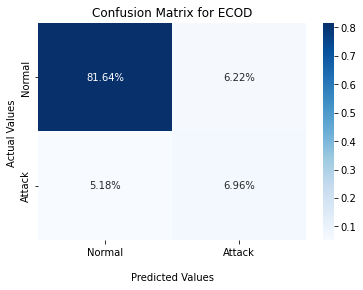

In [127]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for ECOD');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Attack'])
ax.yaxis.set_ticklabels(['Normal','Attack'])

## Display the visualization of the Confusion Matrix.
plt.show()

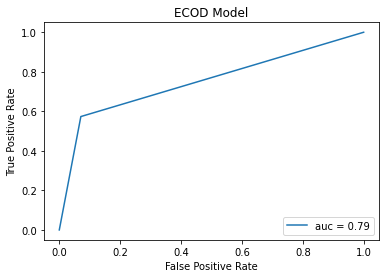

In [128]:
fpr, tpr, _ = metrics.roc_curve(time_label.label,time_label.found)
auc = metrics.roc_auc_score(time_label.label,time_label.pred)
plt.plot(fpr,tpr,label=f"auc = {np.round(auc,2)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ECOD Model')
plt.legend(loc=4)

##Find explanation for un-detected attack

In [406]:
#att no.6 happend in process 2
id_a = 4
t_add = 300
att_score = norm_test_scores[1][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

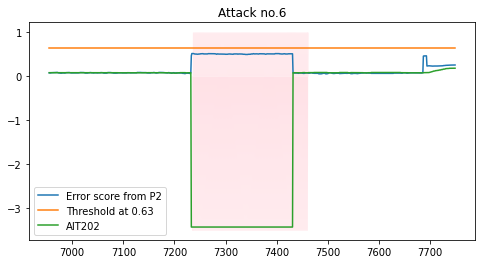

In [389]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P2')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t2]*len(att_score), label=f'Threshold at {np.round(t2,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['AIT202'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='AIT202')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.6")
plt.fill_between(np.arange(idx_start[4]-20,idx_end[4]+11), [-3.5,1]*(226//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

In [390]:
#att no.7 happend in process 3
att_score_7 = norm_test_scores[2][idx_start[5]-t_add:idx_end[5]+t_add]

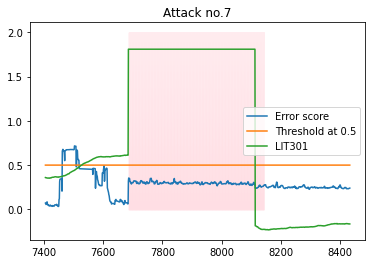

In [394]:
plt.plot(np.arange(idx_start[5]-t_add,idx_end[5]+t_add),att_score_7, label='Error score')
plt.plot(np.arange(idx_start[5]-t_add,idx_end[5]+t_add), [t3]*len(att_score_7), label=f'Threshold at {np.round(t3,2)}')
plt.plot(np.arange(idx_start[5]-t_add,idx_end[5]+t_add), 
         test_scale['LIT301'][idx_start[5]-t_add:idx_end[5]+t_add]
         , label='LIT301')
# plt.vlines(idx_start[5], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[5], ymin=-0.5, ymax=0.8)
plt.title("Attack no.7")
plt.fill_between(np.arange(idx_start[5]-20,idx_end[5]+10), [0,2]*(458//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

In [412]:
#att no.10 happend in process 4
att_score_10 = norm_test_scores[3][idx_start[7]-t_add:idx_end[7]+t_add]
id_a = 7

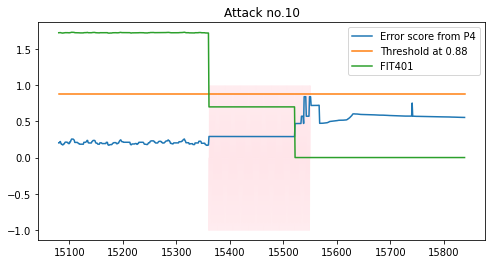

In [429]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score_10, label='Error score from P4')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t4]*len(att_score_10), label=f'Threshold at {np.round(t4,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_df['FIT401'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='FIT401')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=20)
plt.title("Attack no.10")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-1,1]*(190//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

In [457]:
#att no.14 happend in process 3
id_a = 10
att_score_10 = norm_test_scores[2][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

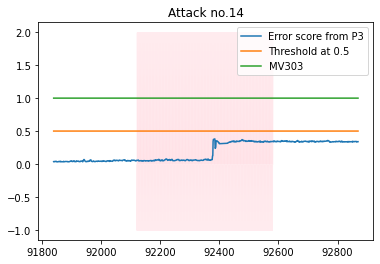

In [458]:
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score_10, label='Error score from P3')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t3]*len(att_score_10), label=f'Threshold at {np.round(t3,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_df['MV303'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='MV303')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=20)
plt.title("Attack no.14")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-1,2]*(460//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

In [509]:
#att no.16 happend in process 3
id_a = 11
att_score_10 = norm_test_scores[2][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

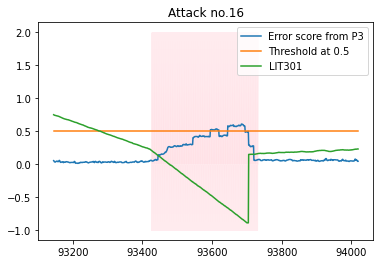

In [531]:
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score_10, label='Error score from P3')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t3]*len(att_score_10), label=f'Threshold at {np.round(t3,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['LIT301'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='LIT301')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=20)
plt.title("Attack no.16")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+11), [-1,2]*(306//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

In [538]:
#att no.20 happend in process 5
id_a = 14
att_score_10 = norm_test_scores[4][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

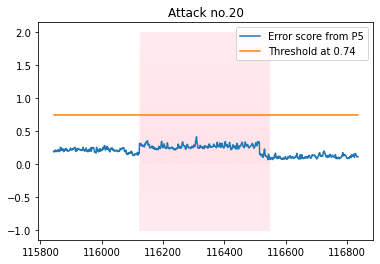

In [556]:
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score_10, label='Error score from P5')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t5]*len(att_score_10), label=f'Threshold at {np.round(t5,2)}')
# plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['AIT504'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
#          , label='AIT504')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=20)
plt.title("Attack no.20")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-1,2]*(424//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

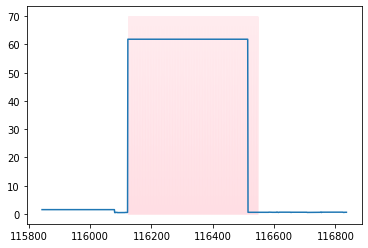

In [557]:
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['AIT504'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='AIT504')
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [0,70]*(424//2), alpha=0.3, 
                 color = 'pink')

In [537]:
time_label[idx_start[14]:]

,Timestamp,label,attack #,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred,found
116143,2015-12-29 18:15:43,1,20,0,0,0,0,0,0,0,0
116144,2015-12-29 18:15:44,1,20,0,0,0,0,0,0,0,0
116145,2015-12-29 18:15:45,1,20,0,0,0,0,0,0,0,0
116146,2015-12-29 18:15:46,1,20,0,0,0,0,0,0,0,0
116147,2015-12-29 18:15:47,1,20,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
449914,2016-02-01 14:59:55,0,0,0,1,0,0,0,0,1,1
449915,2016-02-01 14:59:56,0,0,0,1,0,0,0,0,1,1
449916,2016-02-01 14:59:57,0,0,0,1,0,0,0,0,1,1
449917,2016-02-01 14:59:58,0,0,0,1,0,0,0,0,1,1


#XAI

In [117]:
att_found = np.unique(found)
att_found

array([ 1,  2,  3,  4,  8, 11, 13, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41])

In [111]:
!pip install shap --quiet
!pip install lime --quiet
!pip install alibi[tensorflow] --quiet

In [112]:
import shap
import lime
import lime.lime_tabular
from lime import submodular_pick
from alibi.explainers import ALE

In [ ]:
X_train_summary = shap.kmeans(train_scale, 100)
shap_explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary)
ale = ALE(model.decision_function, feature_names=train_scale.columns)
lm = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')

In [ ]:
def explain_all_attack(att_found,test_scale):
  shap_values = []
  limes = []
  ales = []
  for i in att_found:
    idx = time_label[(time_label["attack #"] == i)].index.values
    n = 100 if len(idx) > 100 else len(idx)
    sample = test_scale[idx[0]:idx[-1]].sample(n = n)
    #shap explainer
    shap_value = shap_explainer.shap_values(X=sample, nsamples=100)
    shap_values.append(np.mean(shap_value,axis=0))

    #lime
    sp_obj = submodular_pick.SubmodularPick(lm, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
    limes.append(sp_obj.sp_explanations[0].as_list())

    #ale
    exp_ale = ale.explain(sample.to_numpy())
    ales.append([np.mean(e) for e in exp_ale.ale_values])

    print(f"---------------------------------- finish XAI attack no {i} ----------------------------")
  
  return shap_values,limes,ales

In [ ]:
shap_values,limes,ales = explain_all_attack(att_found,test_scale)

In [ ]:
#save result
path = '/content/drive/MyDrive/Data_sci_Project/XAI_result'

In [ ]:
import pickle

xai_re = {'shap_values':shap_values,"limes":limes,"ales":ales}

with open(path+'deep_svdd_xai.pkl', 'wb') as fid:
     pickle.dump(xai_re, fid)